In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from yaml import safe_load, YAMLError
from src.snapshots import snapshots_assembly, data_normalization, insert_h5_vector
from src.dim_reduction import SVD, AutoEncoder

2024-01-19 12:50:36,935 - matplotlib - DEBUG - matplotlib data path: /home/bombra/anaconda3/envs/padme/lib/python3.11/site-packages/matplotlib/mpl-data
2024-01-19 12:50:36,941 - matplotlib - DEBUG - CONFIGDIR=/home/bombra/.config/matplotlib
2024-01-19 12:50:36,944 - matplotlib - DEBUG - interactive is False
2024-01-19 12:50:36,945 - matplotlib - DEBUG - platform is linux
2024-01-19 12:50:37,088 - matplotlib - DEBUG - CACHEDIR=/home/bombra/.cache/matplotlib
2024-01-19 12:50:37,090 - matplotlib.font_manager - DEBUG - Using fontManager instance from /home/bombra/.cache/matplotlib/fontlist-v330.json


In [3]:
with open("parameters.yaml", "r") as stream:
    try:
        params = safe_load(stream)
    except YAMLError as exc:
        print(exc)

In [4]:
params

{'snapshots': {'file_type_str': 'h5_fenics',
  'folder': 'data/input',
  'visualization_folder': 'data/visualization',
  'file_name_contains': ['concentration'],
  'normalization': 'standard_scaler',
  'dataset': None},
 'svd': {'trunc_basis': 270,
  'normalization': 'min_max',
  'svd_type': 'randomized_svd',
  'power_iterations': 1,
  'oversampling': 20},
 'auto_encoder': {'batch_size': 300,
  'num_epochs': 10000,
  'learning_rate': '1e-4',
  'weight_decay': '1e-8',
  'loss_function': 'smooth_l1_loss',
  'loss_parameters': {'beta': 0.2},
  'num_workers': 2,
  'number_of_hidden_layers': 5,
  'hidden_layers_sizes': [256, 128, 64, 32, 16],
  'hidden_layers_activation_function': ['leaky_relu',
   'leaky_relu',
   'leaky_relu',
   'leaky_relu',
   ''],
  'hidden_layers_activation_function_parameters': [0.2, 0.2, 0.2, 0.2, 'None'],
  'decoder_activation_function': 'sigmoid',
  'decoder_activation_function_parameter': 'None'}}

In [5]:
filenames, snapshots = snapshots_assembly(params["snapshots"])
snapshots.shape

2024-01-19 12:50:38,205 - src.snapshots - INFO - Starting choice of file type:
2024-01-19 12:50:38,206 - src.snapshots - INFO - FEniCS HDF5 file selected.
Loading Snapshots 2701: 100%|██████████| 2701/2701 [00:37<00:00, 72.86it/s]


(70801, 2702)

In [6]:
# normalized_snapshots, snapshots_normalization_obj = data_normalization(
#     snapshots, params["snapshots"], transpose=True
# )  # extração da média temporal de cada nó
# snapshots.shape

In [7]:
# vector = snapshots_normalization_obj.mean_
# insert_h5_vector(
#     vector,
#     params["snapshots"],
# )

(70801, 290)
(290, 290)


2024-01-19 12:51:24,168 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2024-01-19 12:51:24,171 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.


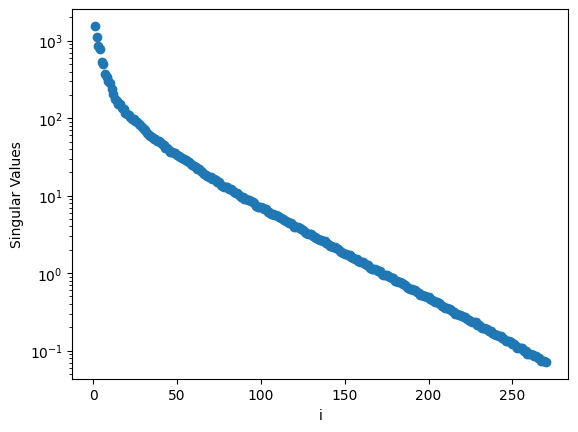

In [8]:
svd_step_randomized = SVD(snapshots, params["svd"])
svd_step_randomized.fit()
svd_step_randomized.plot_singular_values()

In [23]:
projected_snapshots = svd_step_randomized.u.T @ snapshots

projected_snapshots_normalized, u_normalization_obj = data_normalization(
    projected_snapshots, params["svd"], transpose=False
)  # min_max vetores singulares a esquerda
projected_snapshots_normalized.shape

(270, 2702)

In [24]:
# u_normalized[0, :].max()

In [25]:
# vector = u_normalized[:, 0]
# insert_h5_vector(
#     vector,
#     params["snapshots"],
# )

In [26]:
ae_test_2 = AutoEncoder(projected_snapshots_normalized, params["auto_encoder"])
ae_test_2.fit()

# print(ae_test_2.auto_encoder.encoder)
# print(ae_test_2.auto_encoder.decoder)

2024-01-19 16:55:48,092 - src.dim_reduction - INFO - -------------------- Starting training for AutoEncoder --------------------
2024-01-19 16:55:48,093 - src.dim_reduction - INFO -  # of data: torch.Size([2702, 270])
2024-01-19 16:55:48,094 - src.dim_reduction - INFO -  # of layers: 5
2024-01-19 16:55:48,096 - src.dim_reduction - INFO -  Encoder architecture: Sequential(
  (0): Linear(in_features=270, out_features=256, bias=True)
  (1): LeakyReLU(negative_slope=0.2)
  (2): Linear(in_features=256, out_features=128, bias=True)
  (3): LeakyReLU(negative_slope=0.2)
  (4): Linear(in_features=128, out_features=64, bias=True)
  (5): LeakyReLU(negative_slope=0.2)
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): LeakyReLU(negative_slope=0.2)
  (8): Linear(in_features=32, out_features=16, bias=True)
)
/home/bombra/anaconda3/envs/padme/lib/python3.11/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' 

<class 'torch.utils.data.dataloader.DataLoader'>


100%|██████████| 10000/10000 [36:33<00:00,  4.56it/s]


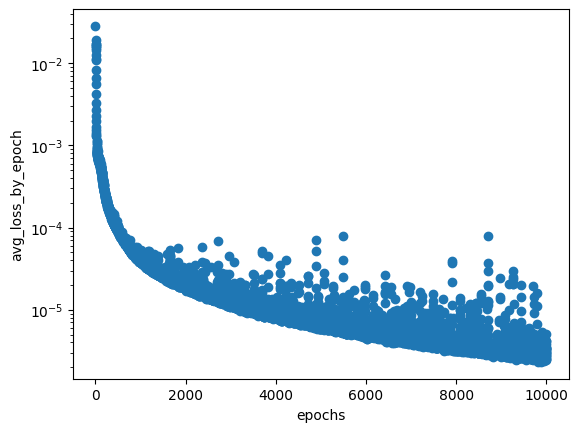

In [27]:
ae_test_2.plot_quantities_per_epoch("avg_loss_by_epoch")

In [30]:
# 1a analise: erro do autoencoder (apenas)

import torch

f_original_autoencoder = projected_snapshots_normalized[:, 0]
f_reconstructed = ae_test_2.auto_encoder.forward(
    torch.tensor(f_original_autoencoder, dtype=torch.float32)
)
print(f_reconstructed.shape)

import numpy as np

np.linalg.norm(
    f_original_autoencoder - f_reconstructed.detach().numpy()
) / np.linalg.norm(f_original_autoencoder, 2)

torch.Size([270])


0.006338466274245669

In [40]:
# 2a analise: erro do snapshot
f_reconstructed = ae_test_2.auto_encoder.forward(
    torch.tensor(projected_snapshots_normalized.T, dtype=torch.float32)
)
f_reconstructed_numpy = f_reconstructed.detach().numpy().T
projected_snapshots_return = u_normalization_obj.inverse_transform(
    f_reconstructed_numpy
)
print(projected_snapshots_return.shape)
print(svd_step_randomized.u.shape)
snapshots_returned = svd_step_randomized.u @ projected_snapshots_return

import numpy as np

snapshot_number = 2500

np.linalg.norm(
    snapshots[:, snapshot_number] - snapshots_returned[:, snapshot_number]
) / np.linalg.norm(snapshots[:, snapshot_number], 2)

vector = snapshots_returned[:, snapshot_number]
insert_h5_vector(
    vector,
    params["snapshots"],
)

vector = snapshots[:, snapshot_number]
insert_h5_vector(vector, params["snapshots"], vector_dir="original_vector")

(270, 2702)
(70801, 270)


In [ ]:
# TODO: train_test_split
# TODO: organizar plots, geração de erros e dados
# TODO: jogar no google docs
# TODO: surrogate